In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='95c715c2-d24f-497b-ae56-6a9b290ac257', project_access_token='p-7f0683f20016bc7f85652519e652faf250391508')
pc = project.project_context


<h3> Imports </h3>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


<h2>Getting the dataset</h2>

In [3]:
df=pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
df.shape

(194673, 38)

<h2>Removing all irrelvant features such as ID's, and desctiptions</h2>

In [5]:
df = df[['SEVERITYCODE', 'X', 'Y',  'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
       'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]
       
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SEVERITYCODE  194673 non-null  int64  
 1   X             189339 non-null  float64
 2   Y             189339 non-null  float64
 3   PERSONCOUNT   194673 non-null  int64  
 4   PEDCOUNT      194673 non-null  int64  
 5   PEDCYLCOUNT   194673 non-null  int64  
 6   VEHCOUNT      194673 non-null  int64  
 7   UNDERINFL     189789 non-null  object 
 8   WEATHER       189592 non-null  object 
 9   ROADCOND      189661 non-null  object 
 10  LIGHTCOND     189503 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 16.3+ MB


<h2>Getting Missing values</h2>

In [6]:
def missing_function(df):
    missing_data = df.isnull()
    missing_data.head()

    for column in missing_data.columns.values.tolist():
        print(column)
        print(missing_data[column].value_counts())
        print(df[column].value_counts())
        print("")
        
missing_function(df)

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64
1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

X
False    189339
True       5334
Name: X, dtype: int64
-122.332653    265
-122.344896    254
-122.328079    252
-122.344997    239
-122.299160    231
              ... 
-122.322768      1
-122.288680      1
-122.405699      1
-122.323578      1
-122.343898      1
Name: X, Length: 23563, dtype: int64

Y
False    189339
True       5334
Name: Y, dtype: int64
47.708655    265
47.717173    254
47.604161    252
47.725036    239
47.579673    231
            ... 
47.556705      1
47.709101      1
47.513899      1
47.565438      1
47.563521      1
Name: Y, Length: 23839, dtype: int64

PERSONCOUNT
False    194673
Name: PERSONCOUNT, dtype: int64
2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44

In [7]:

df.replace(r'^\s*$', np.nan, regex=True)
df.replace("Unknown", np.nan, inplace = True)
df.replace("Other", np.nan, inplace = True)


#removing rows for columns with less than 20% values missing (#UNDERINFL,WEATHER,ROADCOND,LIGHTCOND)
                                                            
df.dropna(subset=["X","Y","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND"], 
          axis=0, inplace=True)

#making sure all missing values are handled with
print(df.info())
missing_function(df)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 166217 entries, 0 to 194672
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SEVERITYCODE  166217 non-null  int64  
 1   X             166217 non-null  float64
 2   Y             166217 non-null  float64
 3   PERSONCOUNT   166217 non-null  int64  
 4   PEDCOUNT      166217 non-null  int64  
 5   PEDCYLCOUNT   166217 non-null  int64  
 6   VEHCOUNT      166217 non-null  int64  
 7   UNDERINFL     166217 non-null  object 
 8   WEATHER       166217 non-null  object 
 9   ROADCOND      166217 non-null  object 
 10  LIGHTCOND     166217 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 15.2+ MB
None
SEVERITYCODE
False    166217
Name: SEVERITYCODE, dtype: int64
1    111503
2     54714
Name: SEVERITYCODE, dtype: int64

X
False    166217
Name: X, dtype: int64
-122.332653    251
-122.344896    240
-122.328079    236
-122.344997    224
-122.299160  

In [8]:
df.head()

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,2,-122.323148,47.703140,2,0,0,2,N,Overcast,Wet,Daylight
1,1,-122.347294,47.647172,2,0,0,2,0,Raining,Wet,Dark - Street Lights On
2,1,-122.334540,47.607871,4,0,0,3,0,Overcast,Dry,Daylight
3,1,-122.334803,47.604803,3,0,0,3,N,Clear,Dry,Daylight
4,2,-122.306426,47.545739,2,0,0,2,0,Raining,Wet,Daylight


In [9]:
df.shape

(166217, 11)

In [10]:
df.describe(include='all')

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
count,166217.000000,166217.000000,166217.000000,166217.000000,166217.000000,166217.000000,166217.000000,166217,166217,166217,166217
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,9,7,7
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,Clear,Dry,Daylight
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87749,106752,119167,110315
mean,1.329172,-122.330338,47.618942,2.511500,0.041374,0.031880,1.973565,NaN,NaN,NaN,NaN
std,0.469914,0.029813,0.056670,1.410457,0.209029,0.177114,0.576237,NaN,NaN,NaN,NaN
min,1.000000,-122.419032,47.495573,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,1.000000,-122.348172,47.574310,2.000000,0.000000,0.000000,2.000000,NaN,NaN,NaN,NaN
50%,1.000000,-122.330276,47.614827,2.000000,0.000000,0.000000,2.000000,NaN,NaN,NaN,NaN
75%,2.000000,-122.311937,47.663664,3.000000,0.000000,0.000000,2.000000,NaN,NaN,NaN,NaN


In [11]:
df['SEVERITYCODE'].value_counts()

1    111503
2     54714
Name: SEVERITYCODE, dtype: int64

<h2>Balanced Dataset</h2>

In [12]:
#shuffling and creating a balanced dataset
df= df.sample(frac=1,random_state=0,replace=False)

# 1 - Put all severity code 2 class in a separate dataset.
df_scode2 = df.loc[df['SEVERITYCODE'] == 2]

# 2 - Randomly select 58188 observations from the severity code 1(majority class)
df_scode1 = df.loc[df['SEVERITYCODE'] == 1].sample(n=54714,random_state=42)

# 3 - concatenating datasets to get balanced dataset
df_balanced = pd.concat([df_scode1,df_scode2])
df_balanced = df_balanced.sample(frac=1,random_state=0,replace=False)

#Replacing 0 with N and 1 with Y as this column has mixed datatype values, making it consistent
df_balanced['UNDERINFL'] = df_balanced['UNDERINFL'].replace(['0'],'N')
df_balanced['UNDERINFL'] = df_balanced['UNDERINFL'].replace(['1'],'Y')

#checking if dataset balanced
print(df_balanced.info())
print(df_balanced['SEVERITYCODE'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109428 entries, 9906 to 73787
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SEVERITYCODE  109428 non-null  int64  
 1   X             109428 non-null  float64
 2   Y             109428 non-null  float64
 3   PERSONCOUNT   109428 non-null  int64  
 4   PEDCOUNT      109428 non-null  int64  
 5   PEDCYLCOUNT   109428 non-null  int64  
 6   VEHCOUNT      109428 non-null  int64  
 7   UNDERINFL     109428 non-null  object 
 8   WEATHER       109428 non-null  object 
 9   ROADCOND      109428 non-null  object 
 10  LIGHTCOND     109428 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 10.0+ MB
None
2    54714
1    54714
Name: SEVERITYCODE, dtype: int64


In [13]:
df_balanced.head()

,SEVERITYCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
9906,1,-122.347301,47.645030,2,0,0,2,N,Raining,Wet,Dark - Street Lights On
119351,1,-122.356906,47.728233,2,0,0,2,N,Clear,Dry,Daylight
75216,1,-122.279013,47.526117,2,0,0,2,N,Clear,Dry,Daylight
24054,1,-122.310660,47.615378,2,0,0,2,N,Clear,Dry,Daylight
82593,1,-122.300601,47.546379,5,0,0,2,N,Clear,Dry,Daylight


In [14]:
for column in df_balanced:
        print(column)
        print(df_balanced[column].value_counts())

SEVERITYCODE
2    54714
1    54714
Name: SEVERITYCODE, dtype: int64
X
-122.344896    186
-122.328079    174
-122.332653    167
-122.344997    155
-122.299160    144
              ... 
-122.398372      1
-122.284939      1
-122.337517      1
-122.386214      1
-122.360942      1
Name: X, Length: 18567, dtype: int64
Y
47.717173    186
47.604161    174
47.708655    167
47.725036    155
47.579673    144
            ... 
47.627977      1
47.698981      1
47.503160      1
47.534065      1
47.668090      1
Name: Y, Length: 18749, dtype: int64
PERSONCOUNT
2     58429
3     23026
4      9931
1      6451
5      4552
0      3440
6      1919
7       852
8       395
9       168
10       99
11       42
12       28
14       15
13       14
17       10
15        9
16        5
18        4
19        3
22        3
25        3
26        3
32        3
29        2
34        2
44        2
23        2
37        2
30        2
48        1
43        1
41        1
39        1
20        1
53        1
28        1
27

<h2>Train and Test split of Dataset</h2>

In [15]:
X = df_balanced.iloc[:,1:]

#Encoding Categorical Features - Training Dataset
X = pd.get_dummies(data=X, columns=['WEATHER','ROADCOND','LIGHTCOND','UNDERINFL'])
                                                            

Y = df_balanced['SEVERITYCODE'].values
print(X.head())
print(X.info())
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

                 X          Y  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
9906   -122.347301  47.645030            2         0            0         2   
119351 -122.356906  47.728233            2         0            0         2   
75216  -122.279013  47.526117            2         0            0         2   
24054  -122.310660  47.615378            2         0            0         2   
82593  -122.300601  47.546379            5         0            0         2   

        WEATHER_Blowing Sand/Dirt  WEATHER_Clear  WEATHER_Fog/Smog/Smoke  \
9906                            0              0                       0   
119351                          0              1                       0   
75216                           0              1                       0   
24054                           0              1                       0   
82593                           0              1                       0   

        WEATHER_Overcast  ...  ROADCOND_Wet  \
9906                 

In [16]:
#Scaling training data as per the requirements
scaler = StandardScaler()
X_train[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']] = scaler.fit_transform(
    X_train[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

#Scaling test data as per the requirements
scaler = StandardScaler()
X_test[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']] = scaler.fit_transform(
    X_test[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 87542 entries, 54893 to 180734
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   X                                   87542 non-null  float64
 1   Y                                   87542 non-null  float64
 2   PERSONCOUNT                         87542 non-null  float64
 3   PEDCOUNT                            87542 non-null  float64
 4   PEDCYLCOUNT                         87542 non-null  float64
 5   VEHCOUNT                            87542 non-null  float64
 6   WEATHER_Blowing Sand/Dirt           87542 non-null  uint8  
 7   WEATHER_Clear                       87542 non-null  uint8  
 8   WEATHER_Fog/Smog/Smoke              87542 non-null  uint8  
 9   WEATHER_Overcast                    87542 non-null  uint8  
 10  WEATHER_Partly Cloudy               87542 non-null  uint8  
 11  WEATHER_Raining                     

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [17]:
X.head()

,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,WEATHER_Blowing Sand/Dirt,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Overcast,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,UNDERINFL_N,UNDERINFL_Y
9906,-122.347301,47.645030,2,0,0,2,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
119351,-122.356906,47.728233,2,0,0,2,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
75216,-122.279013,47.526117,2,0,0,2,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
24054,-122.310660,47.615378,2,0,0,2,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
82593,-122.300601,47.546379,5,0,0,2,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [18]:

missing_function(X_train)
print(X_train.info())
print(X_test.info())


X
False    87542
Name: X, dtype: int64
-0.493157    142
 0.072369    135
-0.081465    133
-0.496543    124
 1.044832    116
            ... 
-0.576663      1
 1.910421      1
-1.701407      1
 0.500299      1
-0.845769      1
Name: X, Length: 17119, dtype: int64

Y
False    87542
Name: Y, dtype: int64
 1.709344    142
-0.268786    135
 1.560236    133
 1.846966    124
-0.697413    116
            ... 
-1.256289      1
 0.771347      1
 0.859889      1
 0.287715      1
 0.988604      1
Name: Y, Length: 17277, dtype: int64

PERSONCOUNT
False    87542
Name: PERSONCOUNT, dtype: int64
-0.393025     46864
 0.303273     18315
 0.999571      7922
-1.089323      5139
 1.695869      3635
-1.785621      2779
 2.392168      1544
 3.088466       700
 3.784764       311
 4.481062       128
 5.177360        75
 5.873658        35
 6.569956        23
 7.962552        11
 7.266254        10
 10.051446        8
 8.658850         6
 9.355148         4
 16.318129        3
 11.444043        3
 20.495918   

<h2>Confusion matrix plot definition</h2>

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


<h2>Logistic Regression</h2>

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[9131 1920]
 [6196 4639]] 

              precision    recall  f1-score   support

           1       0.60      0.83      0.69     11051
           2       0.71      0.43      0.53     10835

    accuracy                           0.63     21886
   macro avg       0.65      0.63      0.61     21886
weighted avg       0.65      0.63      0.61     21886
 

0.6291693319930549 

Confusion matrix, without normalization
[[9131 1920]
 [6196 4639]]


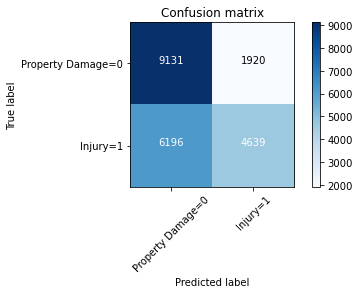

In [20]:
#Fitting and Predictions
lr = LogisticRegression(random_state = 0)
lr.fit(X_train,Y_train)
lr_predictions = lr.predict(X_test)

#Confusion Matrix
lr_cm = confusion_matrix(Y_test,lr_predictions)
print(lr_cm,'\n')

#Classification Report
lr_cr = classification_report(Y_test,lr_predictions)
print(lr_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,lr_predictions)
print(acc,'\n')
accDict = {}
accDict['LR'] = acc

#plot
plt.figure()
plot_confusion_matrix(lr_cm, classes=['Property Damage=0','Injury=1'],normalize= False,  title='Confusion matrix')

<h2> KNN </h2>

1
2
Best Hyperparameter KNN :  {'n_neighbors': 59, 'p': 1}
[[8068 2983]
 [4933 5902]] 

              precision    recall  f1-score   support

           1       0.62      0.73      0.67     11051
           2       0.66      0.54      0.60     10835

    accuracy                           0.64     21886
   macro avg       0.64      0.64      0.63     21886
weighted avg       0.64      0.64      0.64     21886
 

0.6383075938956411 

Confusion matrix, without normalization
[[8068 2983]
 [4933 5902]]


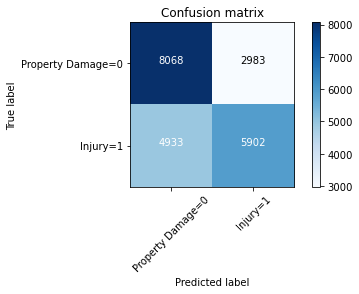

In [21]:
#KNN - neighbor
#Fitting and Predictions
knn = KNeighborsClassifier()
param_grid = {'n_neighbors':[59],'p':[1]}
          
knn1 = GridSearchCV(knn, param_grid , cv=5)
print('1')
knn1.fit(X_train,Y_train)
print('2')
knn_predictions = knn1.predict(X_test)

print('Best Hyperparameter KNN : ',knn1.best_params_)

#Confusion Matrix
knn_cm = confusion_matrix(Y_test,knn_predictions)
print(knn_cm,'\n')

#Classification Report
knn_cr = classification_report(Y_test,knn_predictions)
print(knn_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,knn_predictions)
print(acc,'\n')
accDict['KNN'] = acc

#plot
plt.figure()
plot_confusion_matrix(knn_cm, classes=['Property Damage=0','Injury=1'],normalize= False,  title='Confusion matrix')

<h2>SVC</h2>

1
2


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

3
Best Hyperparameter SVM :  {'kernel': 'linear', 'max_iter': 999, 'random_state': 0}
[[1940 9111]
 [1909 8926]] 

              precision    recall  f1-score   support

           1       0.50      0.18      0.26     11051
           2       0.49      0.82      0.62     10835

    accuracy                           0.50     21886
   macro avg       0.50      0.50      0.44     21886
weighted avg       0.50      0.50      0.44     21886
 

0.49648176916750436 

Confusion matrix, without normalization
[[1940 9111]
 [1909 8926]]


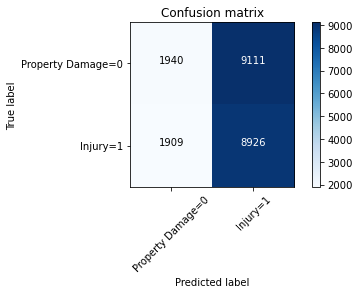

In [22]:
#SVC
#Fitting and Predictions
svc = SVC()
params = {'kernel':['linear'],'max_iter':[999],
          'random_state':[0]}
print('1')
svc1 = GridSearchCV(svc, param_grid=params)
print('2')
svc1.fit(X_train,Y_train)
print('3')
svc_predictions = svc1.predict(X_test)
print('Best Hyperparameter SVM : ',svc1.best_params_)

#Confusion Matrix
svc_cm=confusion_matrix(Y_test,svc_predictions)
print(svc_cm,'\n')

#Classification Report
svc_cr = classification_report(Y_test,svc_predictions)
print(svc_cr,'\n')

#Accuracy

acc = accuracy_score(Y_test,svc_predictions)
print(acc,'\n')
accDict['SVC'] = acc

#plot
plt.figure()
plot_confusion_matrix(svc_cm, classes=['Property Damage=0','Injury=1'],normalize= False,  title='Confusion matrix')

<h2>Decision Tree Classifier</h2>

Best Hyperparameter DTC :  {'criterion': 'gini', 'random_state': 10}
[[6874 4177]
 [4875 5960]] 

              precision    recall  f1-score   support

           1       0.59      0.62      0.60     11051
           2       0.59      0.55      0.57     10835

    accuracy                           0.59     21886
   macro avg       0.59      0.59      0.59     21886
weighted avg       0.59      0.59      0.59     21886
 

0.5864022662889519 

Confusion matrix, without normalization
[[6874 4177]
 [4875 5960]]


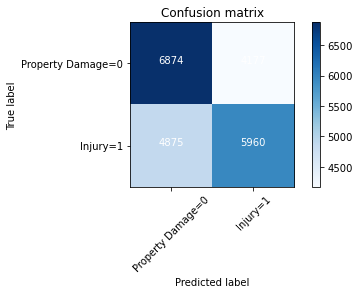

In [23]:
#Fitting and Predictions
dtc = DecisionTreeClassifier()
params = {'criterion':['gini', 'entropy'], 
          'random_state':[10]}
dtc1 = GridSearchCV(dtc, param_grid=params)
dtc1.fit(X_train,Y_train)
dtc_predictions = dtc1.predict(X_test)
print('Best Hyperparameter DTC : ',dtc1.best_params_)

#Confusion Matrix
dtc_cm=confusion_matrix(Y_test,dtc_predictions)
print(dtc_cm,'\n')

#Classification Report
dtc_cr = classification_report(Y_test,dtc_predictions)
print(dtc_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,dtc_predictions)
print(acc,'\n')
accDict['DTC'] = acc

#plot
plt.figure()
plot_confusion_matrix(dtc_cm, classes=['Property Damage=0','Injury=1'],normalize= False,  title='Confusion matrix')

<h1> Result Plotting </h1>

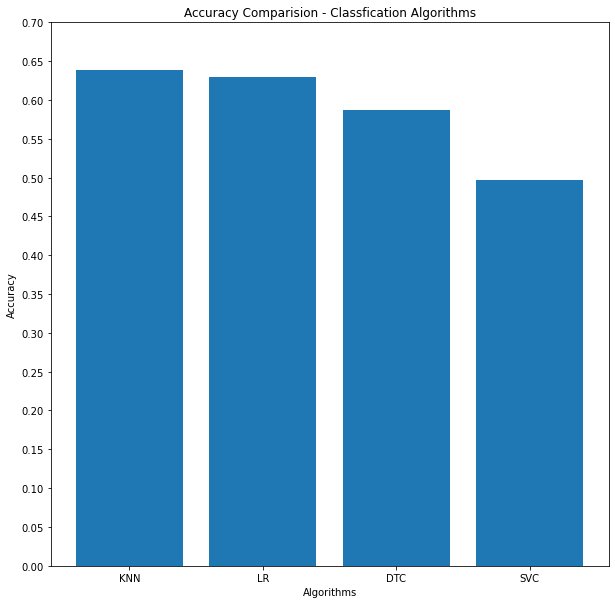

In [24]:

accDict = sorted(accDict.items(), key=lambda x: x[1], reverse=True)
dict1 = {}
for elem in accDict:
    dict1[elem[0]] = elem[1]
Algorithms = dict1.keys()
Accuracy = dict1.values()
plt.figure(figsize=(10,10))
plt.bar(Algorithms, Accuracy)
plt.xlabel('Algorithms')
plt.yticks(np.arange(0,max(Accuracy)+0.1,0.05))
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision - Classfication Algorithms')
plt.show()
